In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [2]:
import json

with open("orda_annotations_0416.json", 'r') as f:
    zune_data = json.load(f)
    print(zune_data.keys())

dict_keys(['reviewannotation', 'reviewsentenceannotation', 'rebuttalsentenceannotation'])


In [4]:
import collections

review_sentence_annotations = zune_data["reviewsentenceannotation"]

various_counter = collections.defaultdict(collections.Counter)
for sent in review_sentence_annotations:
    try:
        labels = json.loads(json.loads(sent["fields"]["labels"]))
    except TypeError:
        labels = json.loads(sent["fields"]["labels"])
    
    if not labels:
        various_counter["length"][0] += 1
    elif not labels["1"]:
        various_counter["length"][1] += 1
    else:
        various_counter["length"][2] += 1
        
    for index, label in labels.items():
        if not label:
            continue
        else:
            for key, val in label.items():
                various_counter[key][val] += 1
        
for k, v in various_counter.items():
    for kk, vv in v.items():
        print(kk, vv)
    print()

1 2122
2 30
0 56

Fact 164
Structuring 598
Evaluative 944
Request 406
Social 28
Other 42

Heading 212
Summary 328
Quote 58

Clarity 226
Motivation/Impact 107
Originality 120
Substance 424
Soundness/Correctness 287
Replicability 70
Meaningful Comparison 83
Other 15

P-Positive 285
N-Negative 779
U-Neutral 263

Typo 71
Result 22
Experiment 82
Edit 77
Explanation 94
Clarification 60



In [42]:


def survey(results, category_names):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('YlGnBu')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(15, 1))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.25 else 'black'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='small')

    return fig, ax


def make_survey(key, actual_name):
    relevant_dict = various_counter[key]
    category_names = []
    values = []
    for k,v in relevant_dict.most_common():
        category_names.append(k)
        values.append(v)
        
    results = {actual_name: values}
    survey(results, category_names)
    plt.show()



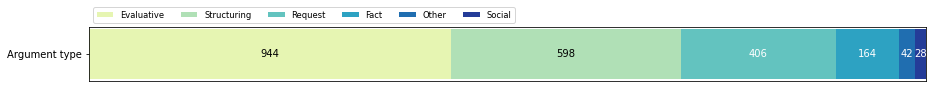

In [43]:
make_survey("arg", "Argument type")

make_survey("asp", "Aspect")

make_survey("pol", "Polarity")

make_survey("struc", "Structuring type")

make_survey("req", "Request type")

In [12]:
print(review_sentence_annotations[0].keys())
ba = set(
    (x["fields"]["review_id"],x["fields"]["initials"])
    for x in review_sentence_annotations)

import collections
annotator_map = collections.defaultdict(list)
for rid, ann in sorted(ba):
    annotator_map[rid].append(ann)
    

dict_keys(['model', 'pk', 'fields'])


In [ ]:
arg_confusions = collections.defaultdict(collections.Counter)

for rid, anns in annotator_map.items():
    if 'example' in rid:
        continue
    if len(anns) < 2:
        continue
    relevant_annotations = [
        i for i in review_sentence_annotations
        if (i["fields"]["review_id"] == rid)]
    annotation_map = collections.defaultdict(list)
    for ann in relevant_annotations:
        annotation_map[ann["fields"]["review_sentence_index"]].append(ann["fields"]["labels"])
    for index, label_jsons in annotation_map.items():
        for i in label_jsons:
            print(json.loads(json.loads(i)))
        print()
        args = []
        for label_json in label_jsons:
            label = json.loads(json.loads(label_json))
            if label:
                args.append(label["0"]["arg"])
        for arg1 in args:
            for arg2 in args:
                a, b = reversed(sorted([arg1, arg2]))
                arg_confusions[a][b] += 1
    
                               
all_arg_names = sorted(arg_confusions.keys())

arg_names = [x for x in all_arg_names if x.startswith("Evaluative") or x.startswith("Request")]

In [ ]:

def confusion_wrapper(arg_names, arg_confusions):
    confusions = np.zeros([len(arg_names), len(arg_names)])
    for i, arg1 in enumerate(arg_names):
        for j, arg2 in enumerate(arg_names):
            confusions[i][j] += arg_confusions[arg1][arg2]
    make_confusion_matrix(confusions, categories=arg_names, percent=False)

In [ ]:
confusion_wrapper(all_arg_names, arg_confusions)

In [ ]:
# Print out: Examples with Social v/s Evaluative
# Evaluative v/s Fact: Show with aspect
# Evaluative v/s Request: Show with aspect
# Fact v/s Structuring: ????
# Evaluative v/s Structuring: ????

rebuttal_sentence_annotations = zune_data["rebuttalsentenceannotation"]



# sentences = [
#     i for i in zune_data
#     if i["model"] == "zune.sentence"]

# sentence_map = collections.defaultdict(dict)
# for sent in sentences:
#     sentence_map[sent["fields"]["comment_id"]][sent["fields"]["sentence_idx"]] = sent["fields"]["text"]
    
    
print(sentence_map)

In [ ]:
import collections

id_to_annotator_map = collections.defaultdict(set)
for x in rebuttal_sentence_annotations:
    id_to_annotator_map[(x["fields"]["rebuttal_id"],x["fields"]["rebuttal_sentence_index"]) ].add(x["fields"]["initials"])

arg_confusions = collections.defaultdict(collections.Counter)
for (rid, idx), anns in id_to_annotator_map.items():
    if 'example' in rid:
        continue
    if len(anns) < 2:
        continue
    relevant_annotations = [
        i for i in rebuttal_sentence_annotations
        if (i["fields"]["rebuttal_id"] == rid) and  (i["fields"]["rebuttal_sentence_index"] == idx)]
    #print(str(collections.Counter(x["fields"]["relation_label"] for x in relevant_annotations)) , end="|")
    #print(sentence_map[rid][idx])
    
    

In [ ]:

                               
all_arg_names = sorted(arg_confusions.keys())
confusion_wrapper(all_arg_names, arg_confusions)

In [ ]:
!python -m pip install --upgrade matplotlib